### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [0]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [0]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На семинаре была рассмотрена одна система. А сейчас будем использовать универсальную систему тегирования universal_tagset 

In [0]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">

Мы имеем массив предложений пар (слово-тег)

In [0]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [0]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [0]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [0]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [0]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

words_dist = nltk.FreqDist(words)
tags_dist = nltk.FreqDist(tags)

tag_num = pd.Series([tags_dist[i] for i in list(set(tags))], index=list(set(tags))).sort_values(ascending=False)  # тег - кол-во тега в корпусе
word_num = pd.Series([words_dist[i] for i in list(set(words))], index=list(set(words))).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [0]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

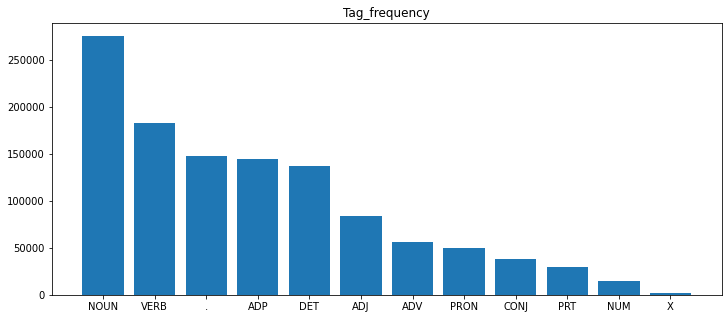

In [0]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [0]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

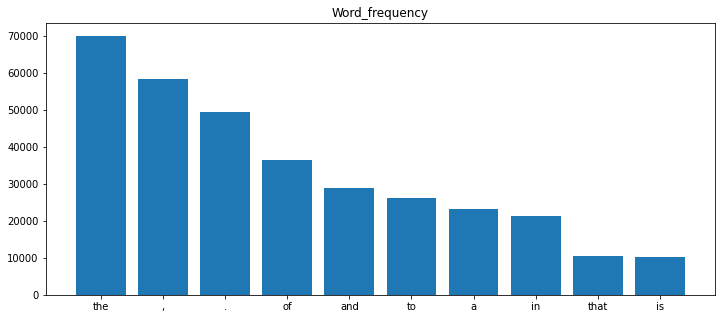

In [0]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

In [0]:
words_dist['cat']

23

### Вопрос 2:
* Самое популярное слово с самым популярным тегом?

In [0]:
tags_dist.most_common(1) # самый популярный тег

[('NOUN', 275558)]

In [0]:
nouns  = np.array(brown_tagged_words)[np.array(brown_tagged_words)[:,1]=='NOUN'][:,0]
mx = np.array([words_dist[none] for none in nouns])
(nouns[np.argmax(mx)], words_dist[nouns[np.argmax(mx)]]) # самое популярное тег с самым популярным словом 'to'

('to', 26158)

In [0]:
from collections import Counter

tp_wrd = [tag for tag,word in brown_tagged_words if word == tag_num.index[0]]
ix = Counter(tp_wrd).most_common(1)[0]
(ix[0], tag_num.index[0]) #самое популярное слово с самым популярным тегом

('time', 'NOUN')

Ответ: time

Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [0]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [0]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))

my_brown_tagged_sents = np.array(my_brown_tagged_sents)
np.random.seed(2)
random_index = np.random.choice([0, 1], len(my_brown_tagged_sents), p=[0.1, 0.9]).astype('bool')
train_sents = my_brown_tagged_sents[random_index]
test_sents = my_brown_tagged_sents[(1 - random_index).astype('bool')]

In [0]:
len(train_sents)

952

In [0]:
len(test_sents)

101

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий наши модели}) = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [0]:
class HiddenMarkovModel:    
    def __init__(self):
    
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]
        
        tag_num = pd.Series([tags_dist[i] for i in list(set(tags))], index=list(set(tags))).sort_values(ascending=False)  # тег - кол-во тега в корпусе
        word_num = pd.Series([words_dist[i] for i in list(set(words))], index=list(set(words))).sort_values(ascending=False) # слово - кол-во слова в корпусе
         
        self.tags = tag_num.index
        self.words = word_num.index
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = 'time'
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    
                    s = self.tags[i_s]
                    
                    # формула (1)
                    q[t + 1][i_s] = np.max(q[t] *
                        self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s])
                    
                    # argmax формула(1)
                    
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t] * self.A.loc[:, s] * 
                        self.B.loc[current_sent[t],s]).reset_index()[s].idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [0]:
# my_model = ..,
my_model = HiddenMarkovModel().fit(train_sents)

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [0]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
my_model.predict(sents)

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

### Вопрос 3:
* Какой тег вы получили для слова `can`?

In [0]:
my_model.predict([['cat']])

OrderedDict([(0, array(['NOUN'], dtype='<U4'))])

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

In [0]:
my_model.predict([['favorite']])

OrderedDict([(0, array(['NOUN'], dtype='<U4'))])

In [0]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        tags = [tag for (word, tag) in sent]
        words = [word for (word, tag) in sent]

        outputs = model.predict([words])[0]

        true_pred += np.sum(tags==outputs)
        num_pred += len(outputs)
    print("Accuracy: %.1f процентов" % (true_pred / num_pred * 100))

In [0]:
accuracy_score(my_model, test_sents)

Accuracy: 89.5 процентов


### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

**Ответ**: 89.5

## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

In [0]:
true_pred = 0
num_pred = 0

for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])

    #outputs = model.predict([words])[0]

    true_pred += np.sum(['NOUN'] * len(words) == tags)
    num_pred += len(words)
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 22.428991185112636 %


Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения) или можете преобразовать код выше

In [0]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger(nltk.FreqDist(tags).max())

In [0]:
true_pred = 0
num_pred = 0

for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])
    
    tagged_sent = default_tagger.tag(words)
    outputs = [tag for token, tag in tagged_sent]
    
    true_pred += np.sum(outputs == tags)
    num_pred += len(words)
    
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 22.428991185112636 %


## Модель Стенфорда

Скачайте предобученную модель от Стэнфорда: https://nlp.stanford.edu/software/tagger.shtml и примените к тестовым данным. 
Не забудьте преобразовать систему тэгов из 'en-ptb' в 'universal' с помощью функции map_tag.

In [0]:
!wget https://nlp.stanford.edu/software/stanford-postagger-full-2018-10-16.zip

--2020-04-20 13:33:28--  https://nlp.stanford.edu/software/stanford-postagger-full-2018-10-16.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134149044 (128M) [application/zip]
Saving to: ‘stanford-postagger-full-2018-10-16.zip.1’

stanford-postagger- 100%[===================>] 127.93M  7.55MB/s    in 16s     

2020-04-20 13:33:45 (7.84 MB/s) - ‘stanford-postagger-full-2018-10-16.zip.1’ saved [134149044/134149044]



In [0]:
! unzip 'stanford-postagger-full-2018-10-16.zip'

Archive:  stanford-postagger-full-2018-10-16.zip
replace stanford-postagger-full-2018-10-16/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: stanford-postagger-full-2018-10-16/README.txt  
  inflating: stanford-postagger-full-2018-10-16/sample-input.txt  
  inflating: stanford-postagger-full-2018-10-16/data/enclitic-inflections.data  
  inflating: stanford-postagger-full-2018-10-16/build.xml  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger.sh  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger-3.9.2-javadoc.jar  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger-gui.sh  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger.jar  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger.bat  
  inflating: stanford-postagger-full-2018-10-16/sample-output.txt  
  inflating: stanford-postagger-full-2018-10-16/stanford-postagger-3.9.2-sources.jar  
  inflating: stanford-postagger-full-2018-10-16/Tag

In [0]:
from nltk.tag.stanford import StanfordPOSTagger
from nltk.tag.mapping import map_tag

# используйте путь до jar и до model
jar = '/content/stanford-postagger-full-2018-10-16/stanford-postagger-3.9.2.jar'
model = '/content/stanford-postagger-full-2018-10-16/models/english-bidirectional-distsim.tagger'
stanford_tagger = StanfordPOSTagger(model, jar, encoding='utf8')

# проверим на предложении
tagged_sent = stanford_tagger.tag(['I', 'bear', 'a', 'bag'])
print('Ответ: ', [map_tag('en-ptb', 'universal', tag) for token, tag in tagged_sent])

/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Ответ:  ['PRON', 'VERB', 'DET', 'NOUN']


### Вопрос 7:
* Какое качество вы получили на модели Стенфорда(округлите до одного знака после запятой)?

In [0]:
true_pred = 0
num_pred = 0

for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])
    
    tagged_sent = stanford_tagger.tag(words)
    outputs = [map_tag('en-ptb', 'universal', tag) for token, tag in tagged_sent]
    
    true_pred += np.sum(outputs == tags)
    num_pred += len(words)
    
print("Accuracy: %.1f процентов" % (true_pred / num_pred * 100))

Accuracy: 88.5 процентов


## BiLSTMTagger

Для того, чтобы успешнее справиться с дальнейшей частью, вам лучше обратиться к семинару 3(Language Model)

### Подготовка данных

Изменим структуру данных

In [0]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

In [0]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'), ('DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [0]:
from torchtext.data import Field, BucketIterator
import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

Теперь формируем наш датасет

In [0]:
# кладем примеры в наш датасет
dataset = torchtext.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734


In [0]:
WORD.build_vocab(train_data, min_freq=2)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 24804
Unique tokens in target (en) vocabulary: 13
['<unk>', '2', 'study', 'beginning', 'movement', 'role', 'assistance', 'hill', 'sets', 'appropriate', 'onto', 'ride', '60', 'bound', 'smell', 'spanish', 'branches', 'unions', 'requirement', 'fees', 'shelters', 'weekly', 'accepting', 'valid', 'systematic', 'sketches', 'linked', 'democracy', 'strengthen', 'i.', 'amy', 'loving', 'and/or', 'invented', 'undertake', 'forum', 'restoration', 'candy', 'inquirer', 'salad', 'bells', 'exterior', 'peaks', 'trifle', 'caravan', 'flooring', 'mornings', 'scots', '46', 'co-operative', "faulkner's", 'lbs.', "prokofieff's", 'tart', 'agreeing', 'catskill', 'disregard', 'gloves', "life's", 'penetrate', 'scepticism', 'timid', '2.5', 'belligerent', 'consoles', 'edible', 'genetic', 'interferometer', 'miners', 'philippines', 'retaliation', 'somers', 'triangle', "'58", 'allocate', 'belched', 'cease-fire', "countin'", 'disordered', 'expansiveness', 'glamor', 'identifiable',

In [0]:
print(vars(train_data.examples[9]))

{'words': ['he', 'was', 'shorter', 'and', 'fatter', 'than', 'owen', ',', 'who', 'felt', 'good', 'standing', 'next', 'to', 'him', '.'], 'tags': ['PRON', 'VERB', 'ADJ', 'CONJ', 'ADJ', 'ADP', 'NOUN', '.', 'PRON', 'VERB', 'ADV', 'VERB', 'ADP', 'ADP', 'PRON', '.']}


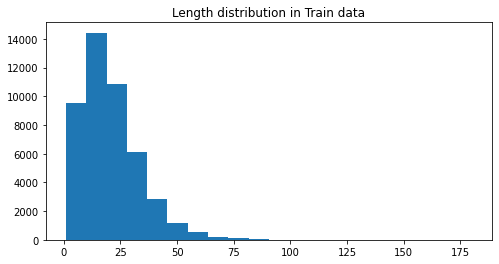

In [0]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [0]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[1434, 180, 180]

### Модель и её обучение

Инициализируем нашу модель

In [0]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False):
        super().__init__()
        
  
        self.embeddings = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, bidirectional=bidirectional, dropout=dropout, num_layers = 2)
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        embedded = self.dropout(self.embeddings(sent))

        output, _ = self.rnn(embedded)
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output)
    
        return prediction
        
# параметры модели
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 200#200
HID_DIM = 128#128
DROPOUT = 0.5#0.5
BIDIRECTIONAL = True

model = LSTMTagger(input_dim=INPUT_DIM, emb_dim=EMB_DIM,
                   hid_dim=HID_DIM, output_dim=OUTPUT_DIM,dropout=DROPOUT, bidirectional=BIDIRECTIONAL).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(24804, 200)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(200, 128, num_layers=2, dropout=0.5, bidirectional=True)
  (tag): Linear(in_features=256, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,697,325 trainable parameters


Наша модель готова, осталось сформировать loss. На семинаре мы искали loss таким образом:

In [0]:
for x in train_iterator:
    break
    
output = model(x.words)
logp = torch.gather(F.log_softmax(output, -1), dim=2, index=x.tags[:,:,None])
-logp.mean()

tensor(2.5074, device='cuda:0', grad_fn=<NegBackward>)

Сейчас мы не будем выбирать только нужные объекты, а сразу воспользуемся помощью pytorch

In [0]:
criterion = nn.CrossEntropyLoss()
criterion(output.view(-1, output.shape[-1]), x.tags.view(-1))

tensor(2.5074, device='cuda:0', grad_fn=<NllLossBackward>)

Погнали обучать

In [0]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        text = batch.words
        tags = batch.tags
        
        optimizer.zero_grad()
        
        output = model(text)
        
        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]
        
        output = output.view(-1, output.shape[-1])
        tags = tags.view(-1)
        
        #tags = [sent len * batch size]
        #output = [sent len * batch size, output dim]
        
        loss = criterion(output, tags)
        
        loss.backward()
        
        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            text = batch.words
            tags = batch.tags

            output = model(text)

            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]

            output = output.view(-1, output.shape[-1])
            tags = tags.view(-1)

            #tags = [sent len * batch size]
            #output = [sent len * batch size, output dim]

            loss = criterion(output, tags)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

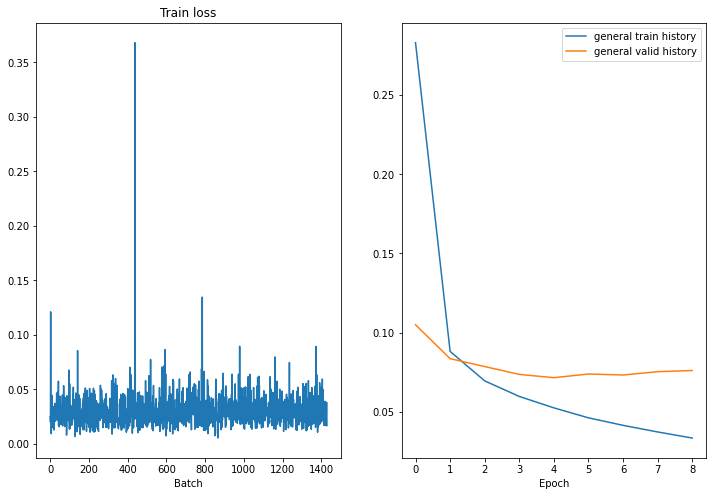

Epoch: 10 | Time: 1m 3s
	Train Loss: 0.031 | Train PPL:   1.031
	 Val. Loss: 0.080 |  Val. PPL:   1.083


In [0]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [0]:
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            text = batch.words
            tags = batch.tags

            output = model(text)
            
            #output = [sent len, batch size, output dim]
            output = output.argmax(-1)
            
            #output = [sent len, batch size]
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(tags.shape)
        
    return round(true_pred / num_pred * 100, 3)

In [0]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 96.465 %


In [0]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

In [0]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_iterator) >= 92

In [0]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [0]:
print_tags(model, pos_data[-1])

From           NOUN
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  NOUN
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .
